<a href="https://colab.research.google.com/github/Coder-Kartikey/ISRO-ForestFire-BAH2025/blob/main/notebooks/03_Unet_FireSegmentation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [17]:
!pip install segmentation-models-pytorch albumentations --quiet

In [18]:
# === 1. SETUP ===
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import segmentation_models_pytorch as smp
from segmentation_models_pytorch.losses import DiceLoss, FocalLoss
from sklearn.model_selection import train_test_split
from sklearn.metrics import jaccard_score, precision_score, recall_score, f1_score
import os
import matplotlib.pyplot as plt
import random
import albumentations as A
from albumentations.pytorch import ToTensorV2
from torch.optim.lr_scheduler import ReduceLROnPlateau

In [19]:
# === 2. LOAD PREPROCESSED DATA ===

from google.colab import drive
drive.mount('/content/drive')

X = np.load('/content/drive/MyDrive/ISRO_ForestFire/data/processed/X_uttarakhand.npy')
Y = np.load('/content/drive/MyDrive/ISRO_ForestFire/data/processed/Y_uttarakhand.npy')

print("Loaded:", X.shape, Y.shape)


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Loaded: (610, 774, 12) (610, 774)


In [20]:
# === 3. PATCHIFY FUNCTION(Old - Only Fire) ===
# def patchify(X, Y, patch_size=128, stride=128):
#     H, W, C = X.shape
#     X_patches, Y_patches = [], []
#     for i in range(0, H - patch_size + 1, stride):
#         for j in range(0, W - patch_size + 1, stride):
#             x_patch = X[i:i+patch_size, j:j+patch_size, :]
#             y_patch = Y[i:i+patch_size, j:j+patch_size]
#             if np.sum(y_patch) > 0:  # keep only fire patches
#                 X_patches.append(x_patch)
#                 Y_patches.append(y_patch)
#     return np.array(X_patches), np.array(Y_patches)

# X_patches, Y_patches = patchify(X, Y, patch_size=128)
# print("Patches:", X_patches.shape, Y_patches.shape)


In [21]:
# === 3. PATCHIFY FUNCTION(New - Fire + No Fire) ===

def patchify_balanced(X, Y, patch_size=128, stride=128, neg_ratio=1.0):
    H, W, C = X.shape
    X_pos, Y_pos = [], []
    X_neg, Y_neg = [], []

    for i in range(0, H - patch_size + 1, stride):
        for j in range(0, W - patch_size + 1, stride):
            x_patch = X[i:i+patch_size, j:j+patch_size, :]
            y_patch = Y[i:i+patch_size, j:j+patch_size]
            if np.sum(y_patch) > 0:
                X_pos.append(x_patch)
                Y_pos.append(y_patch)
            else:
                X_neg.append(x_patch)
                Y_neg.append(y_patch)

    # Sample negative patches up to desired ratio
    num_pos = len(X_pos)
    num_neg = int(num_pos * neg_ratio)
    if len(X_neg) > num_neg:
        neg_indices = random.sample(range(len(X_neg)), num_neg)
        X_neg = [X_neg[i] for i in neg_indices]
        Y_neg = [Y_neg[i] for i in neg_indices]

    # Combine and return
    X_all = np.array(X_pos + X_neg)
    Y_all = np.array(Y_pos + Y_neg)

    print(f"🔥 Fire patches: {len(X_pos)} | 🌲 Non-fire: {len(X_neg)} | Total: {len(X_all)}")
    return X_all, Y_all

X_patches, Y_patches = patchify_balanced(X, Y, patch_size=128, stride=128, neg_ratio=1.0)
print("Patches:", X_patches.shape, Y_patches.shape)

🔥 Fire patches: 19 | 🌲 Non-fire: 5 | Total: 24
Patches: (24, 128, 128, 12) (24, 128, 128)


In [22]:
# === 4. SPLIT ===
X_train, X_val, Y_train, Y_val = train_test_split(X_patches, Y_patches, test_size=0.2, random_state=42)

In [23]:
# === 5. CUSTOM DATASET(Old) ===
# class FireDataset(Dataset):
#     def __init__(self, X, Y):
#         self.X = torch.tensor(X, dtype=torch.float32).permute(0, 3, 1, 2)
#         self.Y = torch.tensor(Y, dtype=torch.float32).unsqueeze(1)

#     def __len__(self): return len(self.X)
#     def __getitem__(self, idx): return self.X[idx], self.Y[idx]

# train_ds = FireDataset(X_train, Y_train)
# val_ds = FireDataset(X_val, Y_val)
# train_loader = DataLoader(train_ds, batch_size=8, shuffle=True)
# val_loader = DataLoader(val_ds, batch_size=8)

In [24]:
# === 5. CUSTOM DATASET(New - Using Augmentations {Albumentations}) ===
class FireDataset(Dataset):
    def __init__(self, X, Y, augment=False):
        self.X = X
        self.Y = Y
        self.augment = augment

        self.transform = A.Compose([
            A.HorizontalFlip(p=0.5),
            A.VerticalFlip(p=0.5),
            A.RandomRotate90(p=0.5),
            A.ShiftScaleRotate(shift_limit=0.1, scale_limit=0.1, rotate_limit=15, p=0.5),
            A.GaussNoise(mean=0, std=10, p=0.3),
            A.RandomBrightnessContrast(p=0.3)
        ])

    def __len__(self): return len(self.X)

    def __getitem__(self, idx):
        x = self.X[idx]
        y = self.Y[idx]
        if self.augment:
            transformed = self.transform(image=x, mask=y)
            x = transformed['image']
            y = transformed['mask']
        x = torch.tensor(x, dtype=torch.float32).permute(2, 0, 1)
        y = torch.tensor(y, dtype=torch.float32).unsqueeze(0)
        return x, y
train_ds = FireDataset(X_train, Y_train, augment=True)
val_ds = FireDataset(X_val, Y_val, augment=False)
train_loader = DataLoader(train_ds, batch_size=8, shuffle=True)
val_loader = DataLoader(val_ds, batch_size=8)

/usr/local/lib/python3.11/dist-packages/albumentations/core/validation.py:114: UserWarning: ShiftScaleRotate is a special case of Affine transform. Please use Affine transform instead.
  original_init(self, **validated_kwargs)
/tmp/ipython-input-24-1554752945.py:13: UserWarning: Argument(s) 'mean, std' are not valid for transform GaussNoise
  A.GaussNoise(mean=0, std=10, p=0.3),


In [25]:
# === 6. MODEL SETUP ===
model = smp.Unet(encoder_name="resnet34", encoder_weights=None, in_channels=X.shape[-1], classes=1)

# Using Focal and Dice Losses
dice = DiceLoss(mode='binary')
focal = FocalLoss(mode='binary', alpha=0.25, gamma=2.0)
def combined_loss(pred, target):
    return 0.5 * dice(pred, target) + 0.5 * focal(pred, target)
loss_fn = combined_loss

optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
scheduler = ReduceLROnPlateau(optimizer, mode='min', patience=3, factor=0.5, verbose=True)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Unet(
  (encoder): ResNetEncoder(
    (conv1): Conv2d(12, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, trac

In [26]:
print("NaNs in X:", np.isnan(X).sum())
print("NaNs in Y:", np.isnan(Y).sum())
print("Infs in X:", np.isinf(X).sum())
print("Max value in X:", np.max(X))
print("Min value in X:", np.min(X))


NaNs in X: 0
NaNs in Y: 0
Infs in X: 0
Max value in X: 6.1937017
Min value in X: -3.5466807


In [27]:
# === 7. TRAINING LOOP ===
def train_epoch():
    model.train()
    total_loss = 0
    for Xb, Yb in train_loader:
        Xb, Yb = Xb.to(device), Yb.to(device)
        optimizer.zero_grad()
        pred = model(Xb)
        loss = loss_fn(pred, Yb)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    return total_loss / len(train_loader)

def eval_epoch():
    model.eval()
    total_loss = 0
    with torch.no_grad():
        for Xb, Yb in val_loader:
            Xb, Yb = Xb.to(device), Yb.to(device)
            pred = model(Xb)
            loss = loss_fn(pred, Yb)
            total_loss += loss.item()
    return total_loss / len(val_loader)

In [28]:
# === Epoch-Wide Metric Calculation ===
def evaluate_metrics(model, val_loader, device, threshold=0.5):
    model.eval()
    y_true_all, y_pred_all = [], []
    with torch.no_grad():
        for xb, yb in val_loader:
            xb = xb.to(device)
            pred = model(xb).sigmoid().cpu().numpy()
            y_true = yb.cpu().numpy()
            y_pred = (pred > threshold).astype(np.uint8)
            y_true_all.extend(y_true.flatten())
            y_pred_all.extend(y_pred.flatten())
    iou = jaccard_score(y_true_all, y_pred_all, zero_division=0)
    f1 = f1_score(y_true_all, y_pred_all, zero_division=0)
    return iou, f1

In [29]:
# === 8. TRAIN ===
epochs = 25
best_iou = 0.0
for epoch in range(epochs):
    train_loss = train_epoch()
    val_loss = eval_epoch()
    iou, f1 = evaluate_metrics(model, val_loader, device)
    scheduler.step(val_loss)
    # print(f"Epoch {epoch+1}: Train Loss = {train_loss:.4f}, Val Loss = {val_loss:.4f}")
    print(f"Epoch {epoch+1}/{epochs} | Train Loss: {train_loss:.4f} | Val Loss: {val_loss:.4f}")
    print(f"📊 IoU: {iou:.4f} | F1: {f1:.4f} | LR: {optimizer.param_groups[0]['lr']:.6f}")
    print("Current LR:", optimizer.param_groups[0]['lr'])

    # Save best model
    if iou > best_iou:
        best_iou = iou
        torch.save(model.state_dict(), '/content/drive/MyDrive/ISRO_ForestFire/models/unet_fire_best.pth')
        print("✅ Best model saved.")

Epoch 1/25 | Train Loss: 0.5690 | Val Loss: 10.2231
📊 IoU: 0.0249 | F1: 0.0486 | LR: 0.001000
Current LR: 0.001
✅ Best model saved.
Epoch 2/25 | Train Loss: 0.5353 | Val Loss: 559.4402
📊 IoU: 0.0363 | F1: 0.0700 | LR: 0.001000
Current LR: 0.001
✅ Best model saved.
Epoch 3/25 | Train Loss: 0.5085 | Val Loss: 44.5516
📊 IoU: 0.0370 | F1: 0.0713 | LR: 0.001000
Current LR: 0.001
✅ Best model saved.
Epoch 4/25 | Train Loss: 0.5013 | Val Loss: 4.1024
📊 IoU: 0.0369 | F1: 0.0712 | LR: 0.001000
Current LR: 0.001
Epoch 5/25 | Train Loss: 0.4911 | Val Loss: 3.1259
📊 IoU: 0.0271 | F1: 0.0528 | LR: 0.001000
Current LR: 0.001
Epoch 6/25 | Train Loss: 0.4855 | Val Loss: 0.8174
📊 IoU: 0.0315 | F1: 0.0610 | LR: 0.001000
Current LR: 0.001
Epoch 7/25 | Train Loss: 0.4822 | Val Loss: 0.5231
📊 IoU: 0.0382 | F1: 0.0736 | LR: 0.001000
Current LR: 0.001
✅ Best model saved.
Epoch 8/25 | Train Loss: 0.4776 | Val Loss: 0.5225
📊 IoU: 0.0315 | F1: 0.0611 | LR: 0.001000
Current LR: 0.001
Epoch 9/25 | Train Loss: 0.4

In [30]:
# === 9. METRICS ON VALIDATION ===
def compute_metrics(y_true, y_pred):
    y_true = y_true.flatten()
    y_pred = (y_pred.flatten() > 0.3).astype(np.uint8)
    iou = jaccard_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred)
    recall = recall_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)
    return iou, precision, recall, f1

model.eval()
sample_X, sample_Y = val_ds[0]
with torch.no_grad():
    pred = model(sample_X.unsqueeze(0).to(device)).sigmoid().cpu().squeeze().numpy()

iou, precision, recall, f1 = compute_metrics(sample_Y.numpy(), pred)
print(f"IoU: {iou:.3f}, Precision: {precision:.3f}, Recall: {recall:.3f}, F1: {f1:.3f}")



IoU: 0.000, Precision: 0.000, Recall: 0.000, F1: 0.000


Sample 0 — Predicted fire pixels: 0
Prediction min/max: 0.024830088 0.36000085


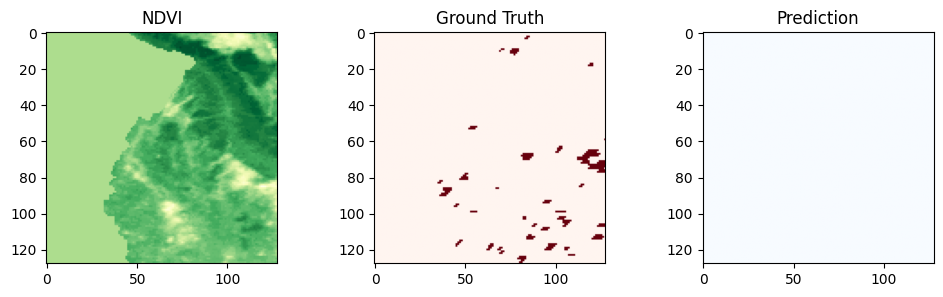

Sample 1 — Predicted fire pixels: 0
Prediction min/max: 0.02488627 0.4431698


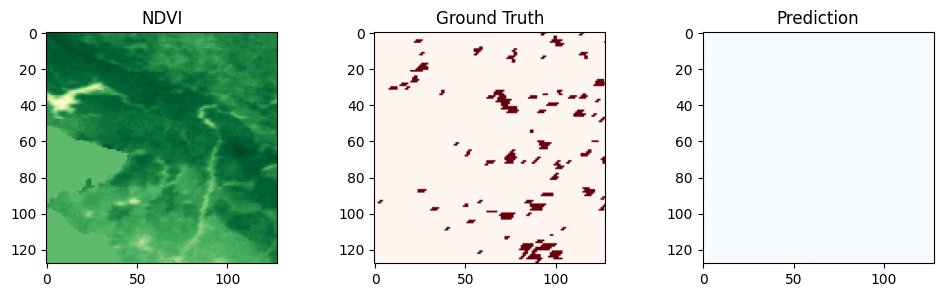

Sample 2 — Predicted fire pixels: 0
Prediction min/max: 0.01706072 0.36917618


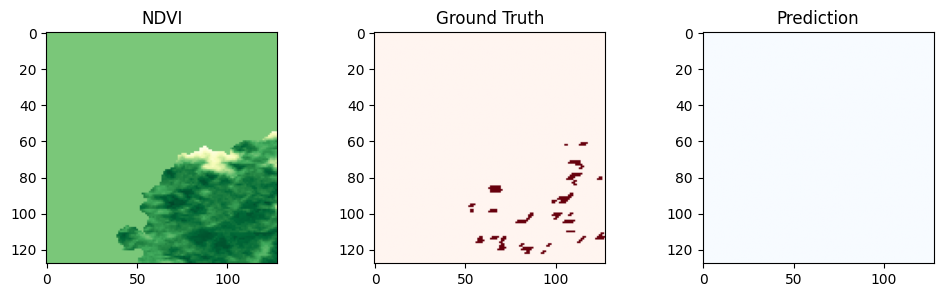

Sample 3 — Predicted fire pixels: 4720
Prediction min/max: 0.024736485 0.7461017


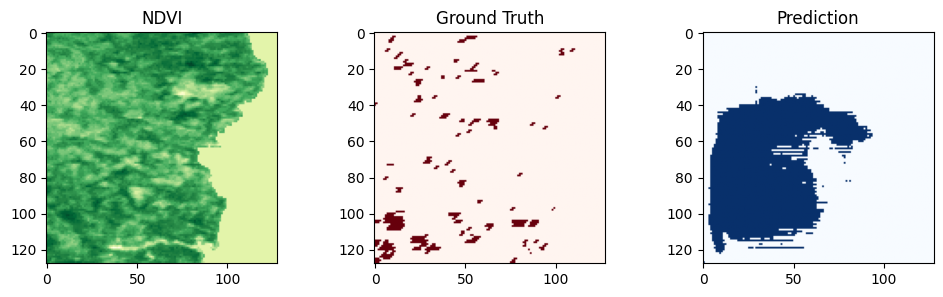

Sample 4 — Predicted fire pixels: 2159
Prediction min/max: 0.0064266506 0.8586026


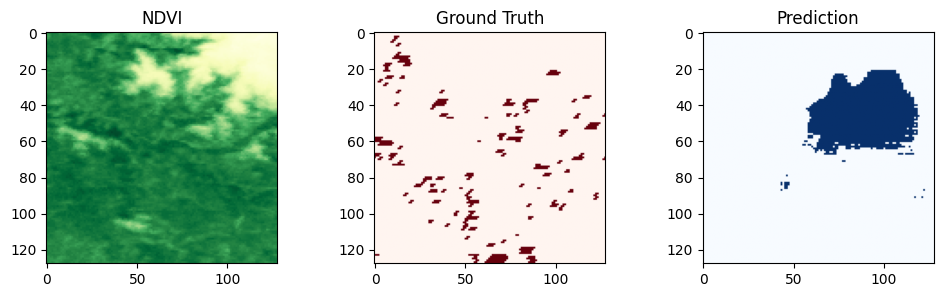

In [31]:
# === 10. VISUALIZE ===
# plt.figure(figsize=(15,4))
# plt.subplot(1,3,1); plt.imshow(sample_X[0], cmap='YlGn'); plt.title("NDVI")
# plt.subplot(1,3,2); plt.imshow(sample_Y[0], cmap='Reds'); plt.title("Ground Truth")
# plt.subplot(1,3,3); plt.imshow(pred > 0.5, cmap='Blues'); plt.title("Prediction")
# plt.tight_layout()
# plt.show()
for i in range(len(val_ds)):
    x, y = val_ds[i]
    with torch.no_grad():
        pred = model(x.unsqueeze(0).to(device)).sigmoid().cpu().squeeze().numpy()
    print(f"Sample {i} — Predicted fire pixels:", np.sum(pred > 0.5))
    print("Prediction min/max:", pred.min(), pred.max())
    plt.figure(figsize=(12,3))
    plt.subplot(1,3,1); plt.imshow(x[0], cmap='YlGn'); plt.title('NDVI')
    plt.subplot(1,3,2); plt.imshow(y[0], cmap='Reds'); plt.title('Ground Truth')
    plt.subplot(1,3,3); plt.imshow(pred > 0.5, cmap='Blues'); plt.title('Prediction')
    plt.show()

In [32]:
# === 11. SAVE MODEL ===
# os.makedirs('/content/drive/MyDrive/ISRO_ForestFire/models', exist_ok=True)
# torch.save(model.state_dict(), '/content/drive/MyDrive/ISRO_ForestFire/models/unet_fire_model.pth')
# print("✅ Model saved.")